# Попрактикуемся с тем, что изучили

Будем практиковаться на датасете:
https://www.kaggle.com/c/avito-demand-prediction

Ваша задача:
1. Создать Dataset для загрузки данных (используем только числовые данные)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

Вопросы? в личку @Kinetikm

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%config InlineBackend.figure_formats = ['svg']

In [2]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            LeakyReLU = nn.LeakyReLU(0.01)
            return LeakyReLU(x)
        if self.activation=="sigmoid":
            Sigmoid = nn.Sigmoid()
            return Sigmoid(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 10 * hidden_dim)
        self.bn2 = nn.BatchNorm1d(10 * hidden_dim)
        self.fc2 = Perceptron(10 * hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dp = nn.Dropout(0.25)
        self.fc3 = Perceptron(hidden_dim, output_dim, "sigmoid")
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.dp(x)
        x = self.fc3(x)
        return x
    
class RMSLE(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(torch.log(y_pred + 1), torch.log(y_true + 1)))

In [3]:
def training(train_loader, model, criterion, optimizer, device, epochs=5, n=200):
    array_loss = []
    for epoch in tqdm(range(epochs)):  
        running_loss = 0.0
        array_loss_batches = []
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % n == 0:
                array_loss_batches.append(running_loss / (i+1))                 
        array_loss.extend(array_loss_batches)    
    return array_loss

In [4]:
def clean_text(text):
    text = str(text)
    text = text.lower()
    clean = re.sub(r"[,.;@#?!&$]+\ *", " ", text)
    return clean

In [5]:
data = pd.read_csv('data/train.csv')
df = pd.DataFrame()

In [6]:
categorial_features = ['user_type','region',
                        'city','parent_category_name','category_name',
                        'param_1','param_2','param_3','description','title']

for col in categorial_features:
    df[col] = LabelEncoder().fit_transform(data[col].fillna('N/A').astype(str).apply(clean_text))


number_features = ['price', 'item_seq_number', 'image_top_1', 'deal_probability']

for col in number_features:
    df[col] = data[col].fillna(0)

In [7]:
target = 'deal_probability'
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), 
                                                    df[target].values, 
                                                    random_state=13, 
                                                    test_size=0.25)

In [8]:
class DFDataset(Dataset):
    
    def __init__(self, X, y):
        assert isinstance(df, pd.DataFrame), 'Аргументом должен быть DataFrame'
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return torch.tensor(self.X.iloc[index], dtype=torch.float32), \
               torch.tensor([self.y[index]], dtype=torch.float32)
    
train = DFDataset(X_train, y_train)
test = DFDataset(X_test, y_test)

In [9]:
train_loader = DataLoader(dataset=train,
                           batch_size=64, 
                           shuffle=True,
                           num_workers=0)
test_loader = DataLoader(dataset=test,
                          batch_size=8, 
                          shuffle=True,
                          num_workers=0)

In [10]:
criterion = RMSLE()

model_Adam = FeedForward(13, 10, 1)
model_Adam.to(device)
optimizer_Adam = torch.optim.Adam(model_Adam.parameters(), lr=0.001)
array_loss_Adam = training(train_loader, model_Adam, criterion, optimizer_Adam, device)

model_SGD = FeedForward(13, 10, 1)
model_SGD.to(device)
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=0.1, momentum=0.9)
array_loss_SGD = training(train_loader, model_SGD, criterion, optimizer_SGD, device)

model_RMSprop = FeedForward(13, 10, 1)
model_RMSprop.to(device)
optimizer_RMSprop = torch.optim.RMSprop(model_RMSprop.parameters(), lr=0.01, momentum=0.9)
array_loss_RMSprop= training(train_loader, model_RMSprop, criterion, optimizer_RMSprop, device)

100%|████████████████████████████████████████████| 5/5 [10:55<00:00, 131.07s/it]


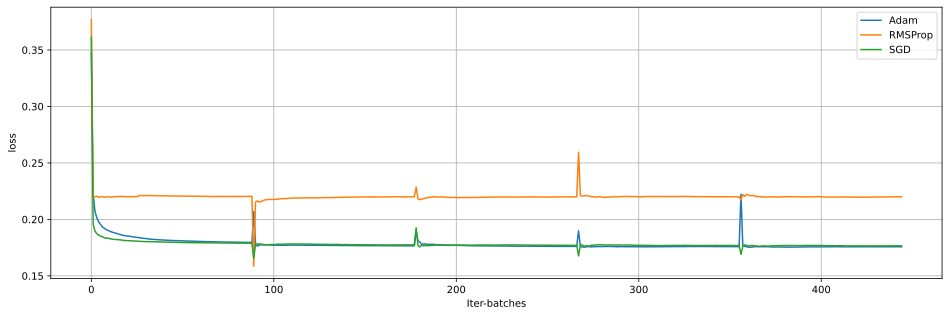

In [11]:
plt.figure(figsize = (16,5))
plt.plot(array_loss_Adam, label = 'Adam')
plt.plot(array_loss_RMSprop, label = 'RMSProp')
plt.plot(array_loss_SGD, label = 'SGD')
plt.xlabel('Iter-batches')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

Итоги работы оптимизаторов на нашем наборе данных:
 - Adam - хорошие результаты, на втором месте по сходимости и потерям, близок к первому месту
 - RMSProp - быстрая сходимость с большими потерями, третье место
 - SGD - лидер по скорости сходимости и точности